# Ingest and process data

This notebook loads the data that was stored on Box, and converts it to dataframe and dataset with a common format across all collections.

It provides functionality for downlaoding images.

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
import chromadb
chromadb.__version__

'0.5.3'

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from weavingtools.collection_tools import SMGCollection, NMSCollection
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image
import chromadb

In [6]:
nms = NMSCollection(img_folder='nms_imgs')
nms.load_original_csvs(files=list(Path('data').glob('NMS_Metadata*.*')))
nms.save_csv('data/NMS.csv')

In [7]:
smg = SMGCollection( img_folder='smg_imgs')
smg.load_from_json('data/smg_objects_06_06_2022.json')
smg.save_csv('data/SMG.csv')

0it [00:00, ?it/s]

#   Download images

In [ ]:
collection = SMGCollection(img_folder=Path('smg_imgs'))
collection.load_from_csv('data/SMG.csv')


In [ ]:
collection.fetch_images(n=10)

In [ ]:
# download images by category
smg_img_overview = pd.read_csv('data/smgimagelookup.csv')
categories = ['Telecommunications', 'Radio Communication','Signalling & Telecommunications',#'Photography','Photographic Technology',
            'Textiles – Plastics', 'Modern Materials', 'Textile Industry', 'Textiles Machinery'
            'Energy – Water Supply & Sanitation', 'Heat Engines (non steam)', 'Metallurgy', 'Hand and Machine Tools', 'Electricity Supply', 'Domestic Appliances', 
            'Tools of the Trade & Personal Accessories', 'Lighting', 'Motive Power', 'Coal Mining', 'Mining & Ore Dressing', 'Gas Industry', 'Heat', 'Nuclear Physics', 
            'Pumping Machinery', "Marine Engines", 'Industrial Metrology', 'Nuclear Energy', 'Environmental Science & Technology', 'Civil Engineering', 'Mechanical Power Transmission'
 ]
comms = smg_img_overview[smg_img_overview.category.isin(categories)]
print(comms.shape)

record_ids = set(comms.record_url.apply(lambda x: x.split('/')[-1]))
collection.fetch_images(record_ids=record_ids)

In [ ]:
collection = NMSCollection(img_folder=Path('nms_imgs'))
collection.load_from_csv('data/NMS.csv')
collection.fetch_images(n=5)

In [ ]:
img_ids = [p for p in collection.df.img_loc.to_list() if isinstance(p,str)]
collection.fetch_images(imgs_ids=img_ids)

# Filter communications data

In [8]:
# open the spreadsheet with image lookup
smg_img_overview = pd.read_csv('data/smgimagelookup.csv')
# select the categories we want to include in the communications collections
categories = ['Telecommunications', 'Radio Communication','Signalling & Telecommunications',#'Photography','Photographic Technology',
            'Textiles – Plastics', 'Modern Materials', 'Textile Industry', 'Textiles Machinery'
            'Energy – Water Supply & Sanitation', 'Heat Engines (non steam)', 'Metallurgy', 'Hand and Machine Tools', 'Electricity Supply', 'Domestic Appliances', 
            'Tools of the Trade & Personal Accessories', 'Lighting', 'Motive Power', 'Coal Mining', 'Mining & Ore Dressing', 'Gas Industry', 'Heat', 'Nuclear Physics', 
            'Pumping Machinery', "Marine Engines", 'Industrial Metrology', 'Nuclear Energy', 'Environmental Science & Technology', 'Civil Engineering', 'Mechanical Power Transmission'
 ]#df_comms = smg_img_overview[smg_img_overview.apply(lambda x: 'commun' in x.category.lower(), axis=1)] 
# select objects from based on these categories
df_comms = smg_img_overview[smg_img_overview.category.isin(categories)]
# get object ids for communication object
object_ids = df_comms.record_url.apply(lambda x: x.split('/')[-1])
print(f'Collected {len(object_ids)} object ids')
smg.df.img_path = smg.df.img_path.apply(lambda x: Path(x)) 
smg.df = smg.df[smg.df.record_id.isin(object_ids)]
smg.df = smg.df[smg.df.img_path.apply(lambda x: x.is_file() and not x.is_dir())].reset_index(drop=True)
smg.df.shape,df_comms.shape

Collected 19657 object ids


((26997, 10), (19657, 6))

In [9]:
nms.df = nms.df[nms.df.img_name.str.endswith('.jpg').fillna(False).astype(bool) &  
                nms.df.img_name.str.startswith(('PF','MP')).fillna(False).astype(bool)
                ].reset_index(drop=True)
nms.df.downloaded = True
nms.df.shape

(1478, 10)

# Create Vector Database

In [10]:
# add collection name to the dataframes to later we can filter by collection
smg.df['collection'] = smg.collection_name; nms.df['collection'] = nms.collection_name
# concatenate the dataframes
collection_df = pd.concat([smg.df,nms.df],axis=0); 
# remove rows for which we don't hvae an image stored locally
collection_df = collection_df[~collection_df.img_path.apply(lambda x: Path(x).is_dir())]
# reset index so we can use it later in the database as ids
collection_df.reset_index(drop=True,inplace=True)
# convert image path to string to aoivd issues with the database
collection_df['img_path'] = collection_df.img_path.apply(lambda x: str(x))
print('Collections has',collection_df.shape[0],'rows')
# save the data to a csv file
collection_df.to_csv('data/heritage_weaver_data.csv')

Collections has 28475 rows


In [11]:
import chromadb
import json
from weavingtools.embedding_tools import SigLIPEmbedder, ImageLoaderRGB, index_data
from weavingtools.linkage_tools import plot_query_results

In [12]:
# select model to use for embedding both text and images
checkpoint = 'google/siglip-base-patch16-224'
# initialise the embedder which we will attach to the database
siglip_embedder = SigLIPEmbedder(checkpoint)
# initate the image loader
data_loader = ImageLoaderRGB()
# initiate the client
client = chromadb.PersistentClient(path="hw")

In [23]:
try:
    client.delete_collection(name="heritage_weaver")
except Exception as e:
    print(e)

In [24]:
# initiate the collection in the database
collection_db = client.get_or_create_collection(
                                            name="heritage_weaver", 
                                            metadata={"hnsw:space": "cosine"}, # we will use cosine distance for similarity search
                                            embedding_function=siglip_embedder, # the embedder for the collection (text and images)
                                            data_loader=data_loader # procedure for loading the image data
                                            )

In [25]:
collection_db.count()

0

In [26]:
index_data(collection_db, collection_df, batch_size=32)

indexing images...


  0%|          | 0/889 [00:00<?, ?it/s]

indexing text...


  0%|          | 0/604 [00:00<?, ?it/s]

In [27]:
collection_db.count()

97587

Miner's lamp check.

Miner's lamp check


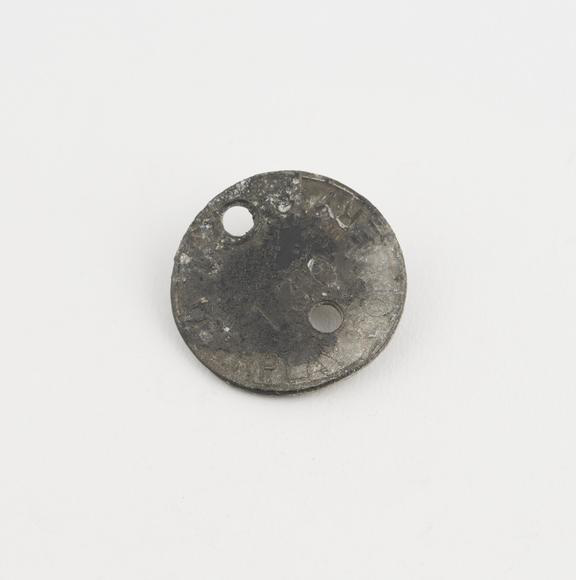

In [28]:

idx = 323
query_img = smg.df[smg.df.downloaded==True].img_path.iloc[idx]
print(smg.df[smg.df.downloaded==True].description.iloc[idx])
Image.open(query_img)

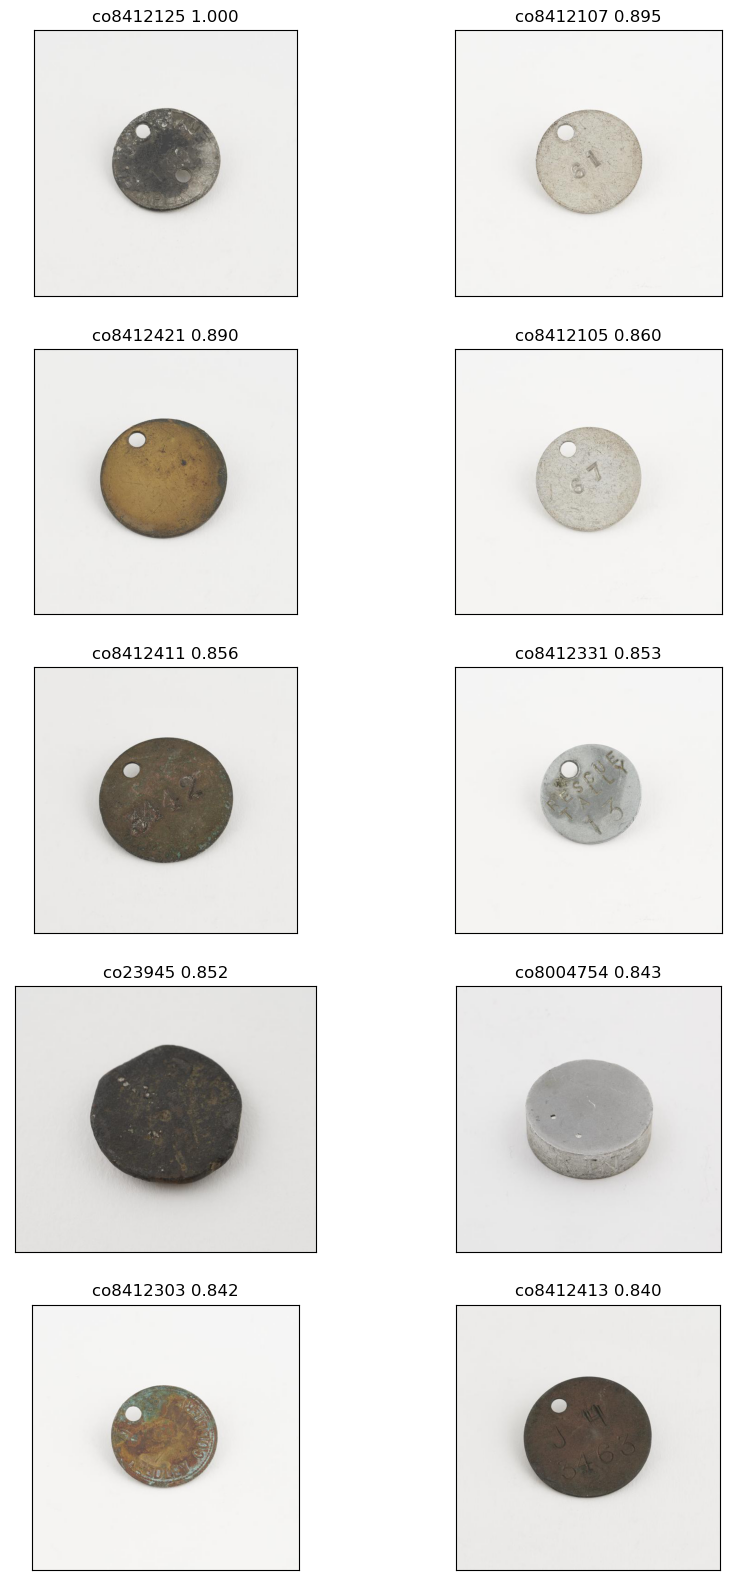

In [29]:
filters = {
    "$and": [
        {
            "modality": {
                "$eq": "image"
            }
        },
        {
            "collection": {
                "$eq" : "smg"
            }
        }
    ]
}

results = collection_db.query(query_uris=[query_img],where=filters, n_results=25)
query_df = plot_query_results(results, collection_df)

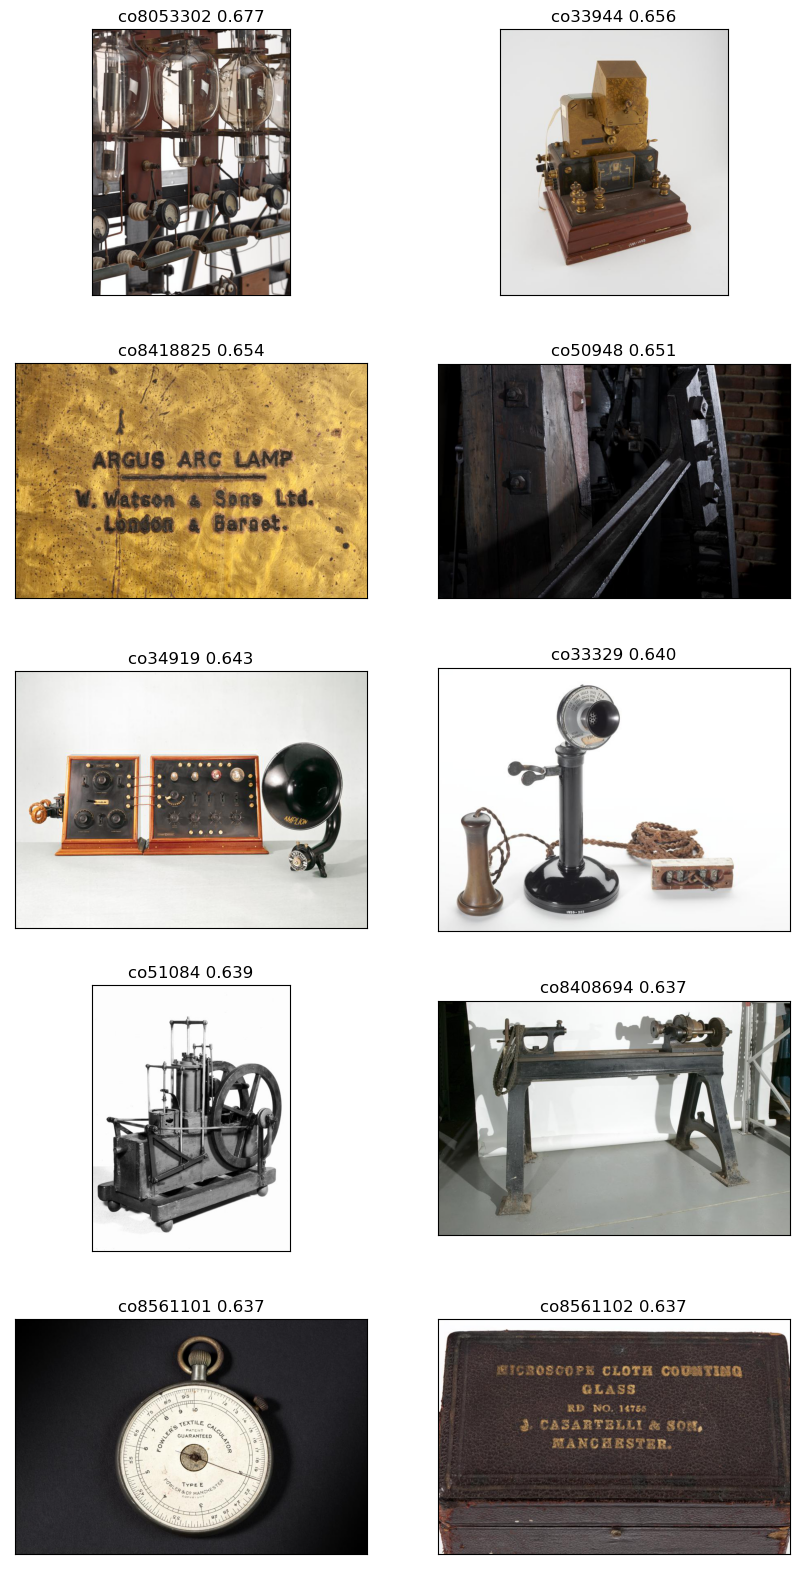

In [21]:
filters = {
    "$and": [
        {
            "modality": {
                "$eq": "text"
            }
        },
        {
            "collection": {
                "$eq" : "smg"
            }
        }
    ]
}


results = collection_db.query(
                query_texts=[
                        """BTH valve, type A.T.26, serial No. 575, (RMW/J89 - McVitie Weston number), by British Thomson-Houston Company Limited."""
                    ],
                where=filters,n_results=100
        )
query_df = plot_query_results(results)

In [ ]:
query_df.description.values[:10]

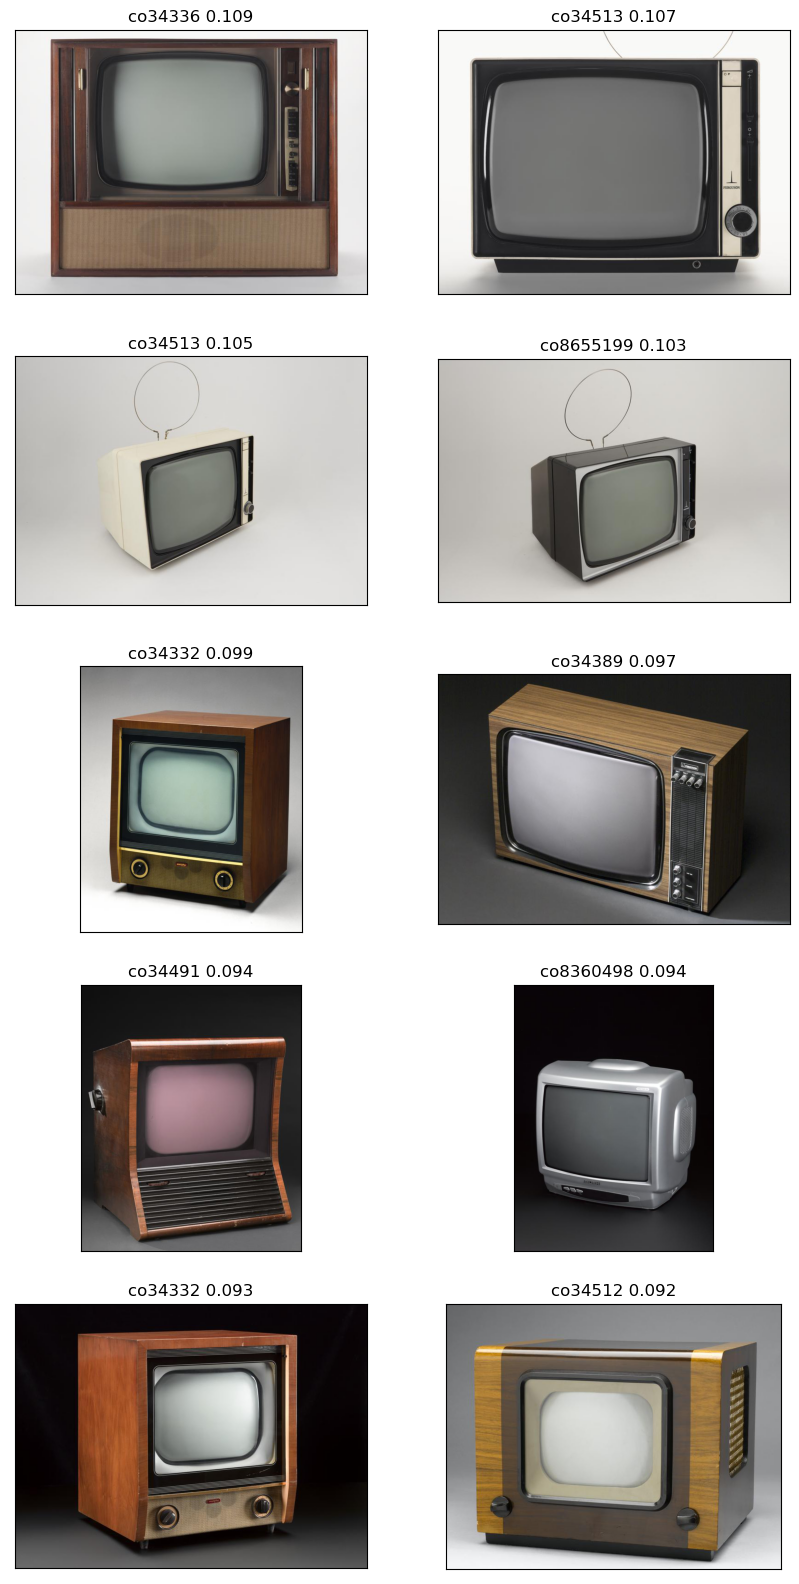

In [38]:
filters = {
    "$and": [
        {
            "modality": {
                "$eq": "image"
            }
        },
        {
            "collection": {
                "$eq" : "smg"
            }
        }
    ]
}
results = collection_db.query(query_texts=["television"],
                             where=filters,#{"modality": "text"},
                             n_results=10)

query_df = plot_query_results(results, collection_df)

In [ ]:
query_df.description.values[:10]

In [ ]:

results = collection_db.query(query_texts=["red telephone"],
                             where={"modality": "image"},
                             n_results=10)

query_df = plot_query_results(results, collection_df)

## Fin.